In [1]:
import lenstronomy

lenstronomy.__version__

import numpy as np
import pandas as pd
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)



from scipy.special import gamma
import paperfig as pf
import collections

import matplotlib as mpl


# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)
#divmap = sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=True)
#sns.palplot(sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=False))

#rgb1 = np.array([59, 76, 192])
#rgb2 = np.array([180, 4, 38])

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

msh_cmap2 = cp.get_msh_cmap(rgb1=np.array([0.085, 0.532, 0.201])*256, rgb2=np.array([0.436, 0.308, 0.631])*256, 
                            ref_point=(160, 160, 160), 
                            num_bins=501, rescale='power', power=1.5)



Base directory path: /data/des80.b/data/chinyi/dinos/paper_dinosI_for_github/dinos-i


In [2]:
def import_data(object_name,band,camera):
    
    data_file = os.path.join(Main_dir, 'cutout/{}/image_{}_{}.h5'.format(object_name,object_name,band))   
    f = h5py.File(data_file, 'r')  
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_time = f['exposure_time'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_time,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }

    # get data and PSF estimate from file 
    psf_file = os.path.join( Main_dir, 'cutout/{}/psf_{}_{}.h5'.format(object_name,object_name,band)) 
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
  #  psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                 #  'psf_error_map': psf_error_map,
                   }
    
    try:
        mask_file = os.path.join(Main_dir, 'cutout/{}/mask_{}_{}.h5'.format(object_name,object_name,band))   
        m = h5py.File(mask_file, 'r') 
        kwargs_mask = m['mask'][()]
        return kwargs_data, kwargs_psf, kwargs_mask
        
    except:
        return kwargs_data, kwargs_psf, None



def Process_Lens(kwargs_data,kwargs_psf,kwargs_mask,radius,x_offset,y_offset):
    # read-in the coordiante system of the exposure

    ra_at_xy_0 = kwargs_data['ra_at_xy_0']
    dec_at_xy_0 = kwargs_data['dec_at_xy_0']
    transform_pix2angle = kwargs_data['transform_pix2angle']
    coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

    # read-in the reduced cutout image
    data_cutout = kwargs_data['image_data']
    numPix = len(data_cutout)

    #ax = plt.figure(figsize=(10, 10)).add_subplot(111)
    #ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-5, vmax=-1.)
    #ax.autoscale(False)

    # estimate point source positions in (ra/dec)
    # im_pos_x_pix = [66.1, 13.1, 50.05, 57.2]
    # im_pos_y_pix = [50.9, 35.8, 58.9, 36.9]
    # im_pos_ra, im_pos_dec = coords.map_pix2coord(im_pos_x_pix, im_pos_y_pix)

    lens_center_ra, lens_center_dec = coords.map_pix2coord(numPix/2, numPix/2)
  #  lens_center_ra=lens_center_ra+x_disp
  #  lens_center_dec=lens_center_dec+y_disp

    x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)
    #x_image, y_image = coords.map_coord2pix(im_pos_ra, im_pos_dec)
    #ax.plot(x_image, y_image, 'or')

    # for i in range(len(x_image)):
    #     ax.text(x_image[i], y_image[i], i, fontsize=20)

    lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)
    #ax.plot(lens_x, lens_y, 'x', color='y', markersize=10)    
    #plt.colorbar()
    #plt.show()


    r_mask_list = [
        [radius], # f390w , is this in arcsec?
        ]

    mask_list = []
    #index_mask_list = []

    for i in range(len(r_mask_list[0])):
        mask_bands = []
        index_mask_bands = []

        for j, kwargs_data in enumerate([kwargs_data]):
            ra_at_xy_0 = kwargs_data['ra_at_xy_0']
            dec_at_xy_0 = kwargs_data['dec_at_xy_0']
            transform_pix2angle = kwargs_data['transform_pix2angle']
            coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
            num_pix = len(kwargs_data['image_data'])

            x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

            r = r_mask_list[j][i]

            mask_outer = mask_util.mask_center_2d(lens_center_ra+x_offset, lens_center_dec+y_offset, r, 
                                                  util.image2array(x_coords), util.image2array(y_coords))

            mask_inner = mask_util.mask_center_2d(lens_center_ra+x_offset, lens_center_dec+y_offset, 0.3, 
                                                  util.image2array(x_coords), util.image2array(y_coords))            
            
            mask = (1 - mask_outer)  * (mask_inner)# * (1 - mask_ext2)

            #mask = 1 - (1 - mask_ext8) * (1 - mask_ext9)
            
            if kwargs_mask is not None:
                provided_mask = kwargs_mask
                provided_mask = np.abs(provided_mask-1)
                mask *= provided_mask.flatten()

                
            mask[mask >= 1] = 1
            mask[mask < 0] = 0

            mask_bands.append(array2image(mask))
            #index_mask_bands.append(index_mask)

        mask_list.append(mask_bands)
        #index_mask_list.append(index_mask_bands)


    for j, kwargs_data in enumerate([kwargs_data]):
        image = kwargs_data['image_data']
        for i in range(len(mask_list)):
            mask = mask_list[i][j]

            
    return mask

def fit_perturber(no,object_name,band,kwargs_data, kwargs_psf, mask, x_offset, y_offset, bound=0.5, save_model_fig=False):
    """
    """
    lens_light_model_list = ['SERSIC_ELLIPSE'] #, 'SERSIC_ELLIPSE']

    kwargs_model = {'lens_light_model_list': lens_light_model_list}
    kwargs_constraints = {}
    kwargs_numerics_galfit = {'supersampling_factor': 1}
    kwargs_likelihood = {'check_bounds': True, 'image_likelihood_mask_list': [mask]}

    image_band = [kwargs_data, kwargs_psf, kwargs_numerics_galfit]
    multi_band_list = [image_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

    # lens light model choices
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []

    # first Sersic component
    fixed_lens_light.append({'n_sersic': 4.})
    kwargs_lens_light_init.append({'R_sersic': .1, 'n_sersic': 4, 'e1': 0, 'e2': 0, 'center_x': x_offset, 'center_y': y_offset})
    kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.5, 'center_y': 0.5})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': x_offset-bound, 
                                    'center_y': y_offset-bound})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': x_offset+bound,
                                    'center_y': y_offset+bound})

    # second Sersic component
#     fixed_lens_light.append({'n_sersic': 1.})
#     kwargs_lens_light_init.append({'R_sersic': .5, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#     kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
#     kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
#     kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    kwargs_params = {'lens_light_model': lens_light_params}

    fitting_seq = FittingSequence(kwargs_data_joint, 
                                  kwargs_model, kwargs_constraints, 
                                  kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 50}]]

    fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    lens_result = kwargs_result['kwargs_lens']
    lens_light_result = kwargs_result['kwargs_lens_light']
    source_result = kwargs_result['kwargs_source']
    ps_result = kwargs_result['kwargs_ps']
    
    
    cmap = pf.cmap
    lensPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                        arrow_size=0.02, cmap_string=cmap,
                        image_likelihood_mask_list=[mask], #kwargs_likelihood['image_likelihood_mask_list'],
                        multi_band_type='multi-linear'
                        )
    

    f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.data_plot(ax=axes[0], band_index=0, cmap=cmap)
    lensPlot.model_plot(ax=axes[1], band_index=0, cmap=cmap)
    lensPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6, cmap=msh_cmap2)
    f.tight_layout()
    #f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    if save_model_fig:
        plt.savefig("Offsets_fits/Fits_{}_{}_{}.png".format(object_name,band,no))
    plt.show()
    plt.clf()

    
    n_sersic = kwargs_result['kwargs_lens_light'][0]['n_sersic']
    r_sersic = kwargs_result['kwargs_lens_light'][0]['R_sersic']
    center_x = kwargs_result['kwargs_lens_light'][0]['center_x']
    center_y = kwargs_result['kwargs_lens_light'][0]['center_y']    
    
    
    return n_sersic, r_sersic, center_x, center_y

def Fit_func(object_name,band,camera,num_dup):
    
    kwargs_data, kwargs_psf,kwargs_mask = import_data(object_name,band,camera)

    mask=Process_Lens(kwargs_data, kwargs_psf,kwargs_mask,1.0,0,0 )

    centerx = []
    centery = []
    no = 0

    #Run fitter at 1 arcsec radius
    for i in range(1):
        n_sersic, R_sersic , center_x, center_y = fit_perturber(no,object_name,band,kwargs_data, kwargs_psf,
                                                                mask, 0, 0, 1.)
        no += 1

    #Run fitter at 0.6 arcsec radius        
    mask=Process_Lens(kwargs_data, kwargs_psf,kwargs_mask,0.6,center_x, center_y )
    for i in range(num_dup):
        if i ==0:
            n_sersic, R_sersic , center_x, center_y = fit_perturber(no,object_name,band,kwargs_data, kwargs_psf,
                                                                mask, center_x, center_y , 1., save_model_fig=True)
        else:
            n_sersic, R_sersic , center_x, center_y = fit_perturber(no,object_name,band,kwargs_data, kwargs_psf,
                                                                mask, center_x, center_y , 1.)
        centerx.append(center_x)
        centery.append(center_y) 
        no += 1
    return [centerx,centery]

def Offset_Fitter(object_name,filter_list,camera_list,num_dup = 4):
    Data={}
    Corr_data={}
    Off_data={}
    
    print("Processing Lens : " +str(object_name))
    
    # Fit data 
    
  #  if len(filter_list) ==1 :
  #      print("Only one filter, nothing to offset")
  #      return None
    
    for i in range(len(filter_list)):
        Data[i] = Fit_func(object_name,filter_list[i],camera_list[i],num_dup=num_dup)

     
    # Find offsets
    for i in range(len(filter_list)): 
        Off_data[i] = [[],[]]
        Off_data[i][0] = [n for n in Data[i][0] ]
        Off_data[i][1] = [n for n in Data[i][1] ]  
        
    
    # Print offset information
    print ("Offsets For lenses system  : ",object_name)
    for i in range(len(filter_list)):    
        Corr_data[i]=[round(np.average(Off_data[i][0]),4),round(np.average(Off_data[i][1]),4)]
        print(filter_list[i],Corr_data[i])
        
    # Plot offset information        
    plt.clf()
    for i in range(len(filter_list)):
        plt.scatter(Off_data[i][0],Off_data[i][1],label=filter_list[i])
        plt.scatter(Corr_data[i][0],Corr_data[i][1],marker="*",color="k")
        plt.axhline(0,color="k")
        plt.axvline(0,color="k")
    plt.plot([0,0.01,0.01],[0.01,0.01,0],color='Tab:blue')    # Grid box for quality checkx
    plt.legend()
    plt.savefig("Offsets_fits/Offsets_{}.png".format(object_name),bbox_inches="tight")        

    # Save offset information into image h5 file
    for i in range(len(filter_list)):
        data_file = os.path.join(Main_dir, 'cutout/{}/image_{}_{}.h5'.format(object_name,object_name,filter_list[i])) 
        f = h5py.File(data_file, 'a') 
        if 'ra_shift' in f:
            del f['ra_shift']
            del f['dec_shift']
        f.create_dataset('ra_shift', data=-Corr_data[i][0])
        f.create_dataset('dec_shift', data=-Corr_data[i][1]) 
        f.close()
        

    return Data




Processing Lens : SDSSJ1627-0053
Computing the PSO ...
10
20
30
40


/home/s1/chinyi/mybin/lenstronomy/lenstronomy/Plots/model_band_plot.py:44: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/s1/chinyi/mybin/lenstronomy/lenstronomy/Plots/model_band_plot.py:103: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/s1/chinyi/mybin/lenstronomy/lenstronomy/Plots/model_band_plot.py:141: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


50
Max iteration reached! Stopping.
-2.511403747639186 reduced X^2 of best position
-2210.035297922484 logL
1760.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 3.6396932898275116, 'n_sersic': 4.0, 'e1': -0.09800191154013625, 'e2': 0.04151548838190686, 'center_x': 0.20305811181234548, 'center_y': 0.07264670752425326}] lens light result
[] point source result
{} special param result
13.759541749954224 time used for  PSO
-2.5028712320752935 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.502871232075294


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


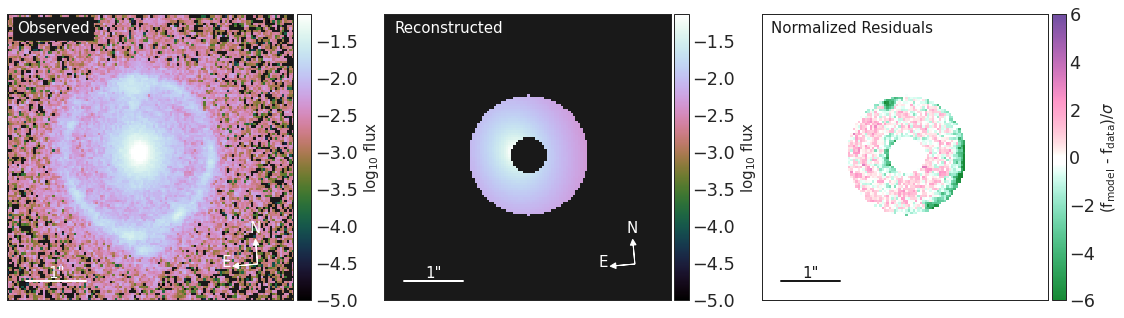

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.8016055220861071 reduced X^2 of best position
-211.62385783073228 logL
528.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.7104595032634842, 'n_sersic': 4.0, 'e1': -0.10151285853865244, 'e2': 0.007657847141667829, 'center_x': 0.1935006224892835, 'center_y': 0.06409755197355713}] lens light result
[] point source result
{} special param result
13.47427225112915 time used for  PSO
-0.7925987184671621 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7925987184671622


<Figure size 432x288 with 0 Axes>

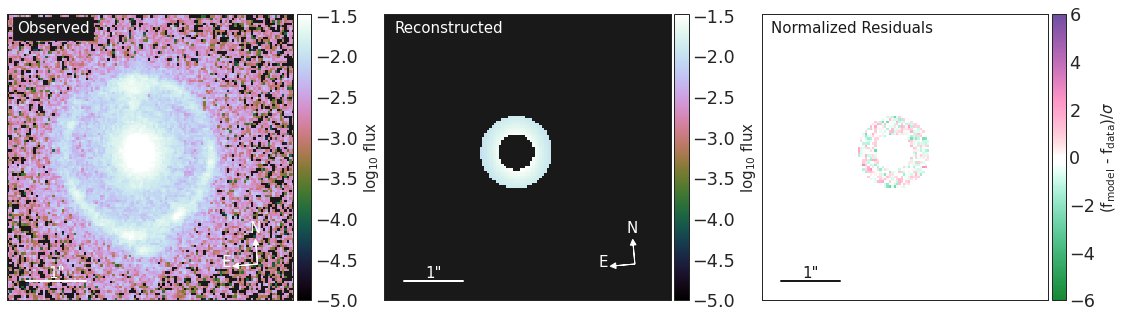

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.8015888482813439 reduced X^2 of best position
-211.6194559462748 logL
528.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.7044576750866265, 'n_sersic': 4.0, 'e1': -0.10105840922925714, 'e2': 0.00814746864263348, 'center_x': 0.19289943294081868, 'center_y': 0.06417712269383744}] lens light result
[] point source result
{} special param result
13.451032638549805 time used for  PSO
-0.7925822320085198 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7925822320085198


<Figure size 432x288 with 0 Axes>

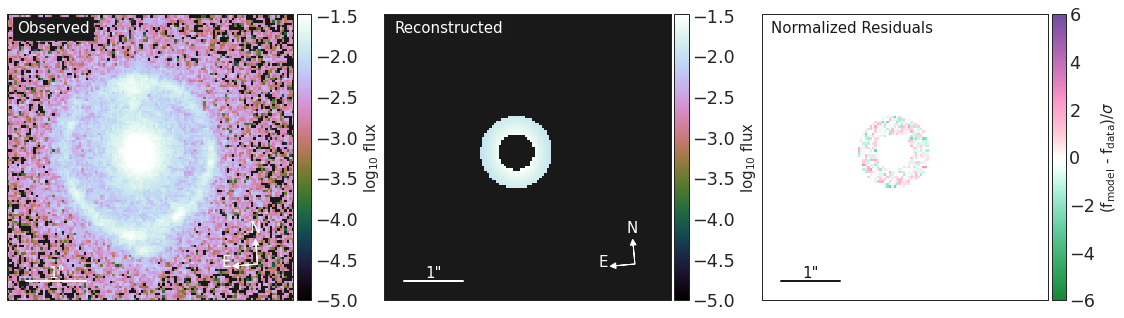

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.8015747152182043 reduced X^2 of best position
-211.61572481760595 logL
528.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.6978205893411398, 'n_sersic': 4.0, 'e1': -0.10185040326810403, 'e2': 0.0073943355288318665, 'center_x': 0.19319811300655884, 'center_y': 0.064496832500184}] lens light result
[] point source result
{} special param result
13.399060487747192 time used for  PSO
-0.7925682577438425 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7925682577438423


<Figure size 432x288 with 0 Axes>

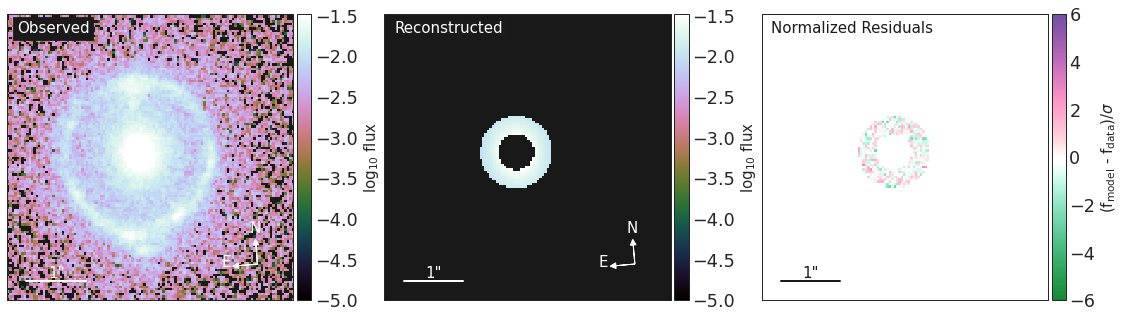

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.801623837978621 reduced X^2 of best position
-211.62869322635595 logL
528.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.7039186468534233, 'n_sersic': 4.0, 'e1': -0.10145958761640504, 'e2': 0.006620424981002224, 'center_x': 0.19285772162019924, 'center_y': 0.0642134369363343}] lens light result
[] point source result
{} special param result
13.429154872894287 time used for  PSO
-0.7926168285631309 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.792616828563131


<Figure size 432x288 with 0 Axes>

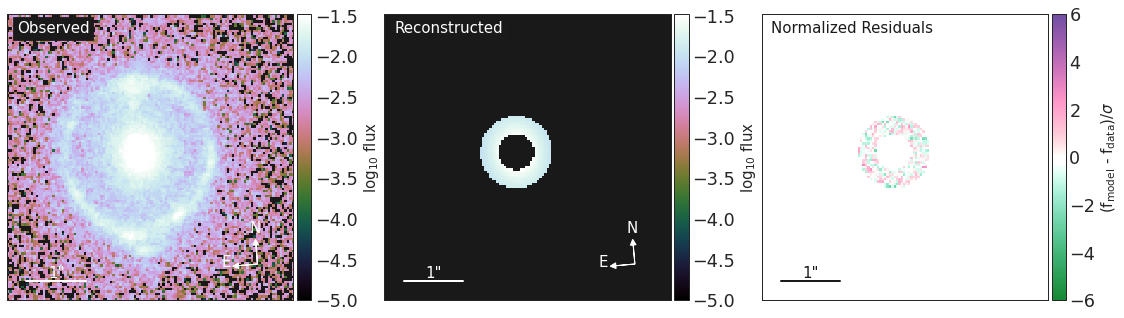

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-2.573013163046582 reduced X^2 of best position
-1464.0444897735051 logL
1138.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.6850261252665266, 'n_sersic': 4.0, 'e1': -0.09377530956311317, 'e2': 0.013404145985572215, 'center_x': 0.20235172424915546, 'center_y': 0.03670658542056608}] lens light result
[] point source result
{} special param result
13.371564865112305 time used for  PSO
-2.5595183387648692 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  2.559518338764869


<Figure size 432x288 with 0 Axes>

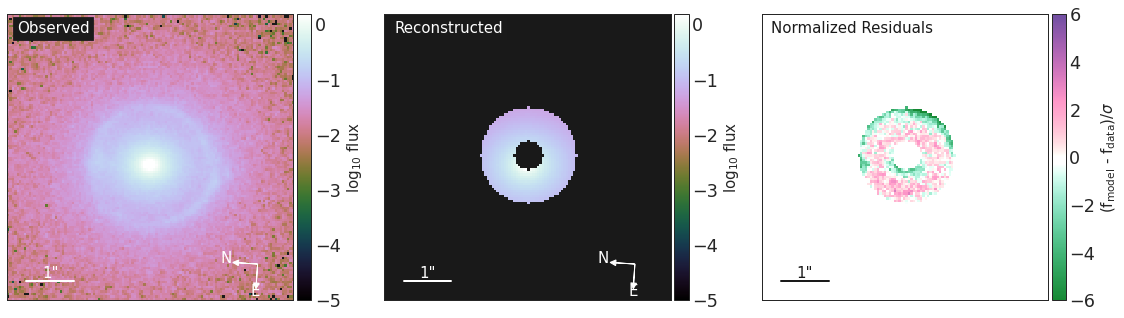

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.6345761021961567 reduced X^2 of best position
-102.16675245358122 logL
322.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1569423638828555, 'n_sersic': 4.0, 'e1': -0.10252564111311642, 'e2': 0.0069770722976641745, 'center_x': 0.19958168920627342, 'center_y': 0.03308726645814451}] lens light result
[] point source result
{} special param result
13.348762273788452 time used for  PSO
-0.6229680027657392 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6229680027657392


<Figure size 432x288 with 0 Axes>

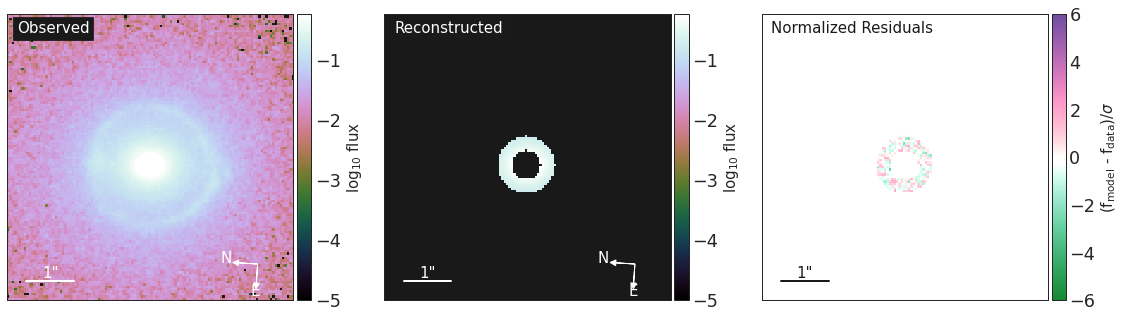

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.6343696174054132 reduced X^2 of best position
-102.13350840227152 logL
322.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1552513899921102, 'n_sersic': 4.0, 'e1': -0.10220598946785489, 'e2': 0.00629172542024134, 'center_x': 0.19959435803077977, 'center_y': 0.03280239261406296}] lens light result
[] point source result
{} special param result
13.258981943130493 time used for  PSO
-0.6227652951358019 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6227652951358018


<Figure size 432x288 with 0 Axes>

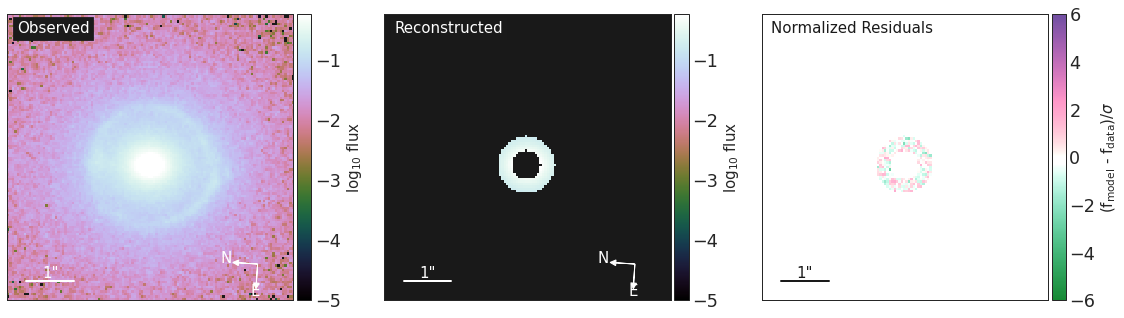

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.6345659030622224 reduced X^2 of best position
-102.1651103930178 logL
322.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1635610393924385, 'n_sersic': 4.0, 'e1': -0.10282971184475719, 'e2': 0.006407761603924423, 'center_x': 0.19929556108183002, 'center_y': 0.032864229721099224}] lens light result
[] point source result
{} special param result
13.281449317932129 time used for  PSO
-0.622957990201328 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.622957990201328


<Figure size 432x288 with 0 Axes>

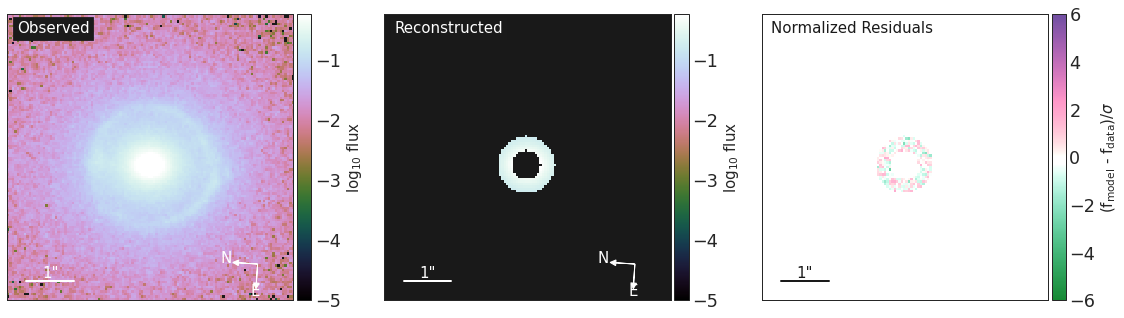

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.6343344142341195 reduced X^2 of best position
-102.12784069169324 logL
322.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.152619774751649, 'n_sersic': 4.0, 'e1': -0.10232558491499477, 'e2': 0.006465525393202298, 'center_x': 0.19941442072273738, 'center_y': 0.032775979568713205}] lens light result
[] point source result
{} special param result
13.254372119903564 time used for  PSO
-0.6227307359249588 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.6227307359249588


<Figure size 432x288 with 0 Axes>

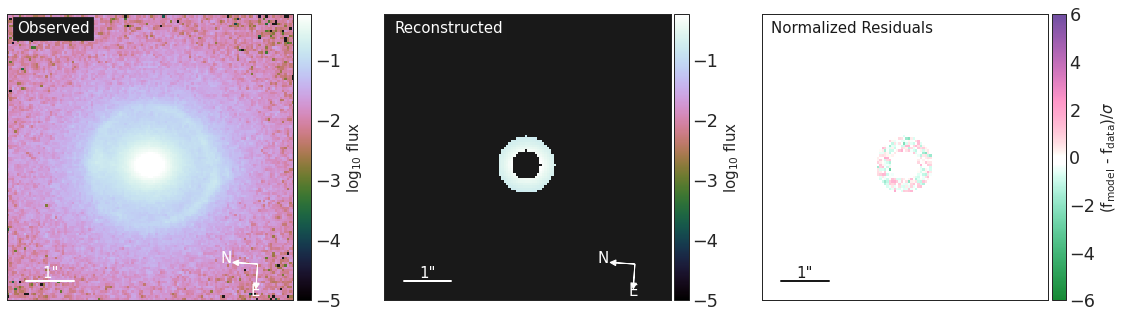

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-6.139591549057374 reduced X^2 of best position
-3493.427591413646 logL
1138.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.5767455458923523, 'n_sersic': 4.0, 'e1': -0.09852618102289327, 'e2': 0.01651733728315787, 'center_x': 0.1634704380386092, 'center_y': 0.03529043367924542}] lens light result
[] point source result
{} special param result
13.421475648880005 time used for  PSO
-6.107390894079801 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  6.107390894079803


<Figure size 432x288 with 0 Axes>

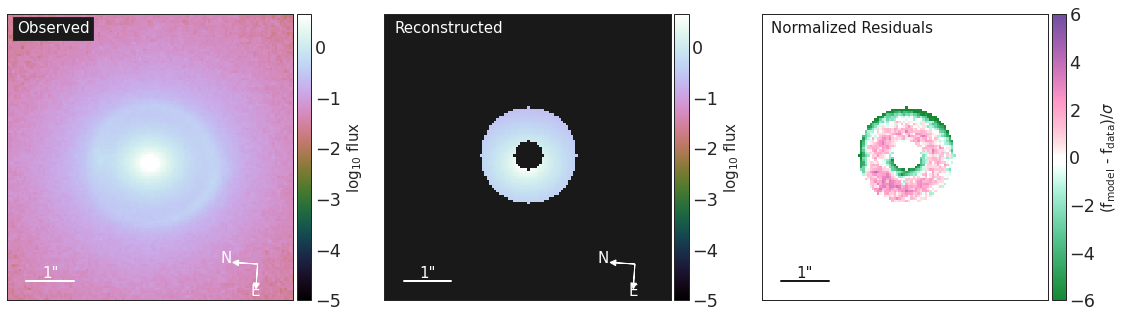

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.7159919327562061 reduced X^2 of best position
-119.92864873666453 logL
335.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1456258236101846, 'n_sersic': 4.0, 'e1': -0.10275008552677835, 'e2': 0.013939751080308552, 'center_x': 0.15989769702300652, 'center_y': 0.03238025576490117}] lens light result
[] point source result
{} special param result
13.432076454162598 time used for  PSO
-0.7033938342326366 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7033938342326366


<Figure size 432x288 with 0 Axes>

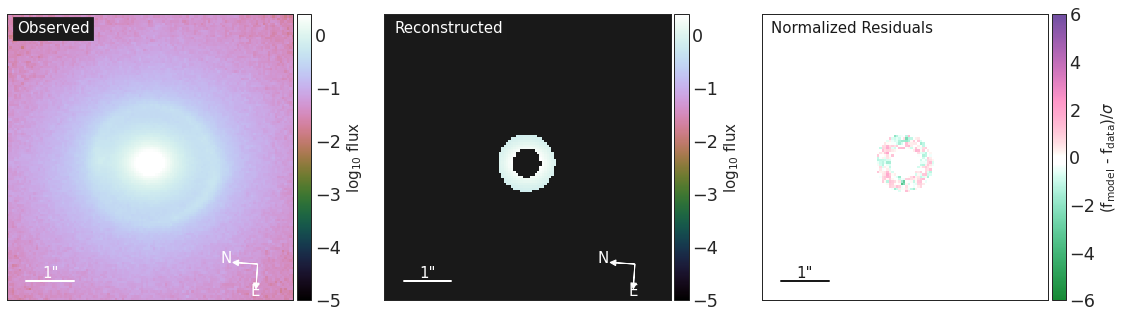

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.7154395437108996 reduced X^2 of best position
-119.83612357157567 logL
335.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1431629402022394, 'n_sersic': 4.0, 'e1': -0.10239618932123132, 'e2': 0.014485955710750748, 'center_x': 0.15998193924018317, 'center_y': 0.03223387923441827}] lens light result
[] point source result
{} special param result
17.232110500335693 time used for  PSO
-0.7028511646426725 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7028511646426725


<Figure size 432x288 with 0 Axes>

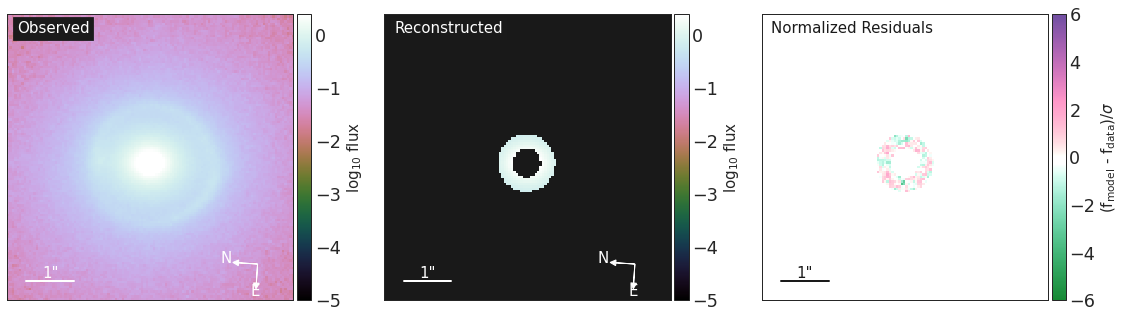

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.7157250832633473 reduced X^2 of best position
-119.88395144661067 logL
335.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1457300427613586, 'n_sersic': 4.0, 'e1': -0.10238930554055475, 'e2': 0.014307150599848394, 'center_x': 0.1600431776134859, 'center_y': 0.03254403004877824}] lens light result
[] point source result
{} special param result
14.209456443786621 time used for  PSO
-0.7031316800387722 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7031316800387722


<Figure size 432x288 with 0 Axes>

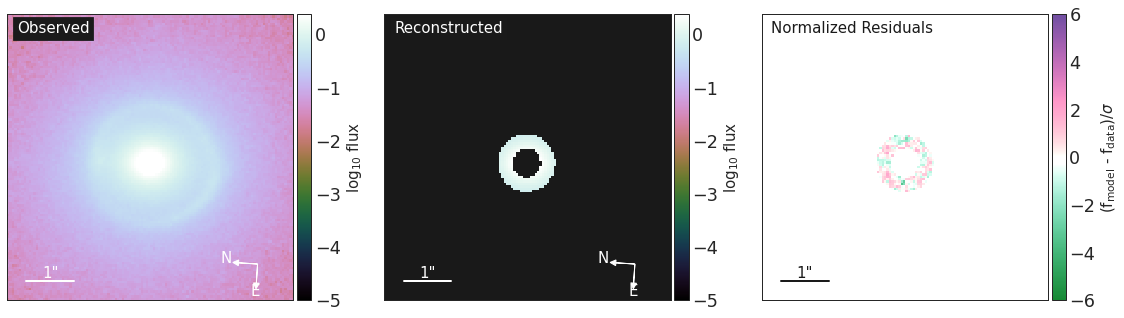

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-0.7164306288798995 reduced X^2 of best position
-120.00213033738316 logL
335.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.1430571002565477, 'n_sersic': 4.0, 'e1': -0.10226712971668948, 'e2': 0.014682717322063565, 'center_x': 0.16022502960432627, 'center_y': 0.03243485398306143}] lens light result
[] point source result
{} special param result
13.313453674316406 time used for  PSO
-0.7038248113629512 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7038248113629518


<Figure size 432x288 with 0 Axes>

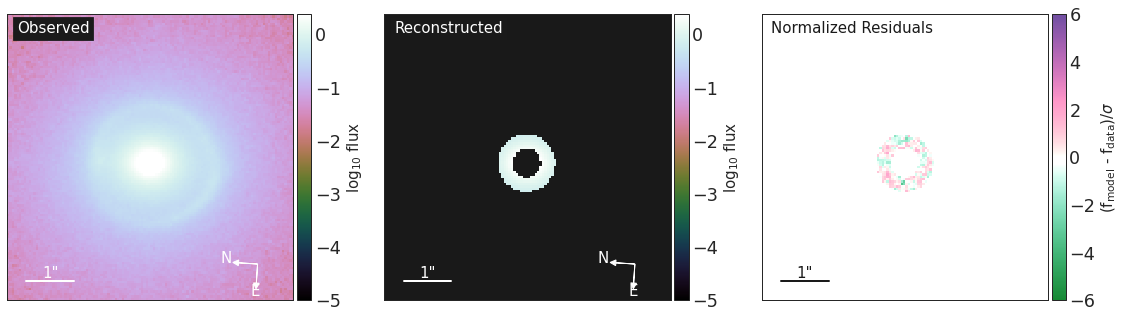

Offsets For lenses system  :  SDSSJ1627-0053
F390W [0.1931, 0.0642]
F555W [0.1995, 0.0329]
F814W [0.16, 0.0324]
Finally Done !


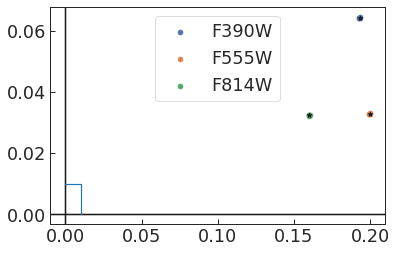

In [3]:
# Note need to create Offsets_fits at notebook directory
Main_dir = '../lenses/'

Processed_Dict = collections.OrderedDict([('SDSSJ1627-0053',[['F390W','F555W','F814W'], ['WFC3','ACS','ACS']])])

Granddata = {}
for key in Processed_Dict:
#    print(key,Processed_Dict[key][0],Processed_Dict[key][1])
    Granddata[key] = Offset_Fitter(key,Processed_Dict[key][0],Processed_Dict[key][1])
print("Finally Done !")